# Content Based Recommender System

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

In [50]:
df = pd.read_csv('anime.csv')
df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [51]:
df.shape

(12294, 7)

In [52]:
df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

We are only building a recommendation system based on the genre and the type, so we are going to work on that only.

# Handling Missing Value

## Handling Missing Rating

In [53]:
df.loc[df['rating'].isnull(), 'rating'] = 0.0
df['rating'].isnull().any()

False

## Handling Missing Types

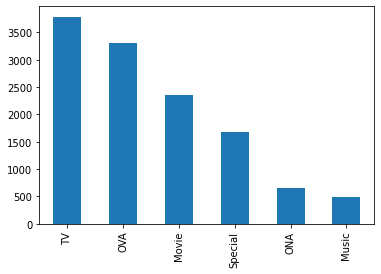

In [54]:
df['type'].value_counts().plot.bar();

The approach to fill missing type based on the number of the episodes. But after checking the data, some of the anime have 'unkonwn' episode and missing type.

In [55]:
df.loc[(df['episodes']=='Unknown') & (df['type'].isnull())].head()

,anime_id,name,genre,type,episodes,rating,members
10898,30484,Steins;Gate 0,"Sci-Fi, Thriller",NaN,Unknown,0.0,60999
10900,34437,Code Geass: Fukkatsu no Lelouch,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",NaN,Unknown,0.0,22748
10906,33352,Violet Evergarden,"Drama, Fantasy",NaN,Unknown,0.0,20564
10907,33248,K: Seven Stories,"Action, Drama, Super Power, Supernatural",NaN,Unknown,0.0,22133
10918,33845,Free! (Shinsaku),"School, Sports",NaN,Unknown,0.0,8666


In [56]:
missing = df.loc[(df['episodes']=='Unknown') & (df['type'].isnull())].copy()
missing.shape

(25, 7)

In [57]:
# Viewign the missign Database
missing

,anime_id,name,genre,type,episodes,rating,members
10898,30484,Steins;Gate 0,"Sci-Fi, Thriller",NaN,Unknown,0.0,60999
10900,34437,Code Geass: Fukkatsu no Lelouch,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",NaN,Unknown,0.0,22748
10906,33352,Violet Evergarden,"Drama, Fantasy",NaN,Unknown,0.0,20564
10907,33248,K: Seven Stories,"Action, Drama, Super Power, Supernatural",NaN,Unknown,0.0,22133
10918,33845,Free! (Shinsaku),"School, Sports",NaN,Unknown,0.0,8666
10949,33475,Busou Shoujo Machiavellianism,"Action, School, Shounen",NaN,Unknown,0.0,1896
10963,31456,Code:Realize: Sousei no Himegimi,"Adventure, Fantasy, Romance, Shoujo",NaN,Unknown,0.0,4017
10983,34332,Flying Babies,NaN,NaN,Unknown,0.0,22
10988,34280,Gamers!,"Comedy, Romance, School",NaN,Unknown,0.0,1045
10990,34485,Ganko-chan,NaN,NaN,Unknown,0.0,11


It seems teh data is not up to date with the current season. There is no other way, We have to manually fill teh type and the episodes.

In [58]:
df.loc[(df['name'] == 'Steins;Gate 0'), 'type'] = 'TV'
df.loc[(df['name'] == 'Steins;Gate 0'), 'episodes'] = '23'

df.loc[(df['name'] == 'Violet Evergarden'), 'type'] = 'TV'
df.loc[(df['name'] == 'Violet Evergarden'), 'episodes'] = '13'

df.loc[(df['name'] == 'Code Geass: Fukkatsu no Lelouch'), 'type'] = 'TV'
df.loc[(df['name'] == 'Code Geass: Fukkatsu no Lelouch'), 'episodes'] = '25'

df.loc[(df['name'] == 'K: Seven Stories'), 'type'] = 'Movie'
df.loc[(df['name'] == 'K: Seven Stories'), 'episodes'] = '6'

df.loc[(df['name'] == 'Free! (Shinsaku)'), 'type'] = 'TV'
df.loc[(df['name'] == 'Free! (Shinsaku)'), 'episodes'] = '12'

df.loc[(df['name'] == 'Busou Shoujo Machiavellianism'), 'type'] = 'TV'
df.loc[(df['name'] == 'Busou Shoujo Machiavellianism'), 'episodes'] = '12'

df.loc[(df['name'] == 'Code:Realize: Sousei no Himegimi'), 'type'] = 'TV'
df.loc[(df['name'] == 'Code:Realize: Sousei no Himegimi'), 'episodes'] = '12'

df.loc[(df['name'] == 'Gamers!'), 'type'] = 'TV'
df.loc[(df['name'] == 'Gamers!'), 'episodes'] = '12'

df.loc[(df['name'] == 'Ganko-chan'), 'type'] = 'TV'
df.loc[(df['name'] == 'Ganko-chan'), 'episodes'] = '10'

df.loc[(df['name'] == 'Ginga Eiyuu Densetsu (2017)'), 'type'] = 'OVA'
df.loc[(df['name'] == 'Ginga Eiyuu Densetsu (2017)'), 'episodes'] = '110'

df.loc[(df['name'] == 'Grancrest Senki'), 'type'] = 'TV'
df.loc[(df['name'] == 'Grancrest Senki'), 'episodes'] = '24'

df.loc[(df['name'] == 'IDOLiSH7'), 'type'] = 'TV'
df.loc[(df['name'] == 'IDOLiSH7'), 'episodes'] = '17'

df.loc[(df['name'] == 'Isekai Shokudou'), 'type'] = 'TV'
df.loc[(df['name'] == 'Isekai Shokudou'), 'episodes'] = '12'

df.loc[(df['name'] == 'Oushitsu Kyoushi Haine'), 'type'] = 'TV'
df.loc[(df['name'] == 'Oushitsu Kyoushi Haine'), 'episodes'] = '12'

df.loc[(df['name'] == 'Peace Maker Kurogane (Shinsaku)'), 'type'] = 'TV'
df.loc[(df['name'] == 'Peace Maker Kurogane (Shinsaku)'), 'episodes'] = '23'

df.loc[(df['name'] == 'Seikaisuru Kado'), 'type'] = 'TV'
df.loc[(df['name'] == 'Seikaisuru Kado'), 'episodes'] = '12'

df.loc[(df['name'] == 'UQ Holder!'), 'type'] = 'TV'
df.loc[(df['name'] == 'UQ Holder!'), 'episodes'] = '12'

df.loc[(df['name'] == 'Citrus'), 'type'] = 'TV'
df.loc[(df['name'] == 'Citrus'), 'episodes'] = '12'

df.loc[(df['name'] == 'Hitorijime My Hero'), 'type'] = 'TV'
df.loc[(df['name'] == 'Hitorijime My Hero'), 'episodes'] = '12'


In [59]:
df.isnull().sum()

anime_id     0
name         0
genre       62
type         6
episodes     0
rating       0
members      0
dtype: int64

There are still some Unknown 'type', because it has not yet aired. I will drop those anime.

In [60]:
df.dropna(subset=['type'], inplace=True)
df.shape

(12288, 7)

## Handling Unkown Genre

In [61]:
df.isnull().sum()

anime_id     0
name         0
genre       61
type         0
episodes     0
rating       0
members      0
dtype: int64

In [62]:
df[df['genre'].isnull()]

,anime_id,name,genre,type,episodes,rating,members
2844,33242,IS: Infinite Stratos 2 - Infinite Wedding,NaN,Special,1,7.15,6604
3541,33589,ViVid Strike!,NaN,TV,12,6.96,12345
6040,29765,Metropolis (2009),NaN,Movie,1,6.27,313
6646,32695,Match Shoujo,NaN,ONA,1,6.02,242
7018,33187,Katsudou Shashin,NaN,Movie,1,5.79,607
...,...,...,...,...,...,...,...
11070,32032,Seikaisuru Kado,NaN,TV,12,0.00,1797
11086,34310,Tamagotchi Movie: Tanpen Himitsu no Otodoke Da...,NaN,Movie,1,0.00,51
11097,34474,Tsukipro The Animation,NaN,TV,Unknown,0.00,843
11112,33035,Yuyushiki Special,NaN,Special,1,0.00,2294


For now, let's just fill it with 'Unknown'.

In [63]:
df['genre'].fillna('Unknown', inplace=True)
df.isnull().any()

anime_id    False
name        False
genre       False
type        False
episodes    False
rating      False
members     False
dtype: bool

# Build the recommender System

### Calculate Weighted Rating

Maybe it is also a good idea to show the weighted rating to the user whenever they query for similar anime. We can improve their respective weighted rating.

In [64]:
m = df.members.quantile(0.75)
c = df.rating.mean()
print(m, c)

9448.5 6.355887858072916


In [65]:
def weighted_rating(df, m, c):
    term = df['members'] / (m + df['members'])
    return df['rating'] * term + (1-term) * c

In [66]:
df['community_rating'] = df.apply(weighted_rating, axis = 1, args=(m, c))
df.head()

,anime_id,name,genre,type,episodes,rating,members,community_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,9.234437
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,9.225834
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,9.028960
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,9.131071
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,8.995145


## Dropping some unused columns
These are the features that will be dropped:
* anime_id -> just the index of the anime, it is easier if we use panda's index.
* rating -> we have weighted_rating(community_rating)
* episodes -> the data that we have is not updated with the airing anime, and some anime is stil airing(One piece, etc.)


In [67]:
df.drop(['anime_id', 'rating', 'members', 'episodes'], axis=1, inplace=True)
df.head()

,name,genre,type,community_rating
0,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,9.234437
1,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,9.225834
2,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,9.028960
3,Steins;Gate,"Sci-Fi, Thriller",TV,9.131071
4,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,8.995145


## Breakdown the genre and type
We want our algorithm to treat the 'type' and 'genre' of anime as equal. Therefore if we use label encoding, maybe algorithm will treat a certain category more important than the other categories.

In [68]:
df = pd.concat([df,df['type'].str.get_dummies(), df['genre'].str.get_dummies(sep = ',')],axis=1)
df.head()

,name,genre,type,community_rating,Movie,Music,ONA,OVA,Special,TV,...,Shounen,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,Yaoi
0,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,9.234437,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,9.225834,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,9.028960,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,Steins;Gate,"Sci-Fi, Thriller",TV,9.131071,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,8.995145,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [69]:
anime_features = df.loc[:, "Movie":].copy()
anime_features.head()



,Movie,Music,ONA,OVA,Special,TV,Adventure,Cars,Comedy,Dementia,...,Shounen,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,Yaoi
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Calculate the similarity matrix

In [70]:
cosine_sim = cosine_similarity(anime_features.values,
anime_features.values)
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.31622777],
       [0.        , 1.        , 0.375     , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.375     , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.5       ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.5       ],
       [0.31622777, 0.        , 0.        , ..., 0.5       , 0.5       ,
        1.        ]])

In [71]:
cosine_sim.shape

(12288, 12288)

Now we must create an indexing for each anime name, this will be used when user querying a recommendation.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [72]:
anime_index = pd.Series(df.index, index=df.name).drop_duplicates()

In [73]:
def anime_recommendation(anime_name, similarity=cosine_sim):
    idx = anime_index[anime_name]

    # Get the pairwise simalirity scores of all anime with that anime
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the anime based on the simalirity scores
    sim_scores = sorted(sim_scores,key=lambda x:x[1],reverse= True)

    # Get the scores of the 10 most similar anime
    sim_scores = sim_scores[0:11]

    # Get the anime indices
    anime_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar anime
    result = df[['name','genre','community_rating']].iloc[anime_indices].drop(idx)

    return result

In [74]:
anime_recommendation("Steins;Gate")

,name,genre,community_rating
10898,Steins;Gate 0,"Sci-Fi, Thriller",0.852459
3581,Fireball Charming,Sci-Fi,6.574226
7984,Hanoka,Sci-Fi,6.040040
8910,Hoshi no Ko Poron,Sci-Fi,6.360831
10079,RoboDz,Sci-Fi,6.338184
10858,Yuusei Kamen,Sci-Fi,6.356795
10975,Escha Chron,Sci-Fi,5.861462
59,Steins;Gate Movie: Fuka Ryouiki no Déjà vu,"Sci-Fi, Thriller",8.504498
126,Steins;Gate: Oukoubakko no Poriomania,"Sci-Fi, Thriller",8.342360
196,Steins;Gate: Kyoukaimenjou no Missing Link - D...,"Sci-Fi, Thriller",7.946121


We see that it is very reasonable that Steins;Gate 0 is the most similar anime, because it is the alternate endign of Steins;Gate. The rating is very low because Steins;Gate 0 was a new anime when the data is collected.